In [1]:
import requests
import pandas as pd
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import PIL
import cv2
import seaborn as sns

from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


# Helper functions for visualization:

In [2]:
# from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, 
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    From scikit-learn: plots a confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    #fixes "squishing of plot"
    plt.ylim([1.5, -.5]) 
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

def plot_model_history(history, n_epochs):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training Loss')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation Loss')
    ax[0].set_title('Loss Curves')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training Accuracy')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
    ax[1].set_title('Accuracy Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')

In [3]:
df0 = pd.read_fwf('PCC_cat.txt', header=None)
# df0
# df0[21] # 21 is the label entry index

# Here we have 7 unique labels:

In [4]:
labels = np.unique(df0[21])

# Make a dataframe of the images and associated labels

In [5]:
# access ra and dec from their columns in the datagframe
ra = df0[2]
dec = df0[3]

# filenames = []
# for r, d in zip(ra, dec):
#     fn = f'sdss_ra={r}_dec={d}.jpeg'
#     filenames.append(fn)

# df1 = pd.DataFrame({'files' : filenames,
#                     'labels': df0[21]})    


In [6]:
bright = np.where(df0[4] <= 19.4)
brightDF = df0.iloc[bright].copy()

labels = np.unique(brightDF[21])


# Check balance of labels/data

In [7]:
def checkBalance(df):
    all_labels = df['labels']
    all_labels = all_labels.tolist()
    balance = df['labels'].value_counts()
    print(balance)
    for i in range(len(balance)):
        print(f'{balance[i]*100/df.size:.2f} %')

In [8]:
# access ra and dec from their columns in the datagframe
ra = brightDF[2]
dec = brightDF[3]

filenames = []
for r, d in zip(ra, dec):
    fn = f'sdss_ra={r}_dec={d}.jpeg'
    filenames.append(fn)

brightDF_reduced = pd.DataFrame({'files' : filenames,
                                 'labels': brightDF[21]})    

In [9]:
# checkBalance(brightDF_reduced)

In [10]:
df1 = brightDF_reduced
unique_labels = np.unique(df1['labels'])

# unique_labels

In [11]:
clusterBG_LTG = df1.loc[(df1['labels']==unique_labels[0])]
BG_ETG = df1.loc[(df1['labels']==unique_labels[1])]
clusterBG_edgeDisk = df1.loc[(df1['labels']==unique_labels[2])]
likely_dE_ETGcluster = df1.loc[(df1['labels']==unique_labels[3])]
likely_merging = df1.loc[(df1['labels']==unique_labels[4])]
poss_dE_ETGcluster = df1.loc[(df1['labels']==unique_labels[5])]
weak_bg = df1.loc[(df1['labels']==unique_labels[6])]

In [12]:
downSampleDf0 = pd.concat([clusterBG_LTG, # 384
                         BG_ETG.sample(frac = 400/3008),
                         clusterBG_edgeDisk.sample(frac = 400/1049),
                         likely_dE_ETGcluster, # 398
                         likely_merging, # 23
                         poss_dE_ETGcluster, # 98
                         weak_bg # 477
                         ])
# checkBalance(downSampleDf0)

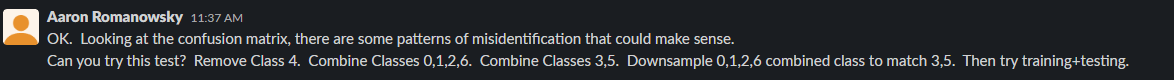

In [13]:
def replace(df, ind):
    label = list(df['labels'])[0]
    newDf = df.replace(label, str(ind))
    return(newDf)

In [14]:
# combined 3 and 5
second = pd.concat([
                    replace(likely_dE_ETGcluster, 1), # old 3
                    replace(poss_dE_ETGcluster, 1) # old 5
                    ])
# combine 0,1,2,6
first = pd.concat([replace(clusterBG_LTG, 0), # old 0
                   replace(BG_ETG, 0), # old 1
                   replace(clusterBG_edgeDisk, 0), # old 2
                   replace(weak_bg, 0) # old 6 
                    ])

lenSecond = len(second.index)
lenFirst = len(first.index)

downSampleDf1 = pd.concat([first.sample(frac = lenSecond/lenFirst), second])

# 0 is background
# 1 is dE/ETGcluster

# Generate Rotation data


In [15]:
file = downSampleDf1['files'].to_numpy()
label = downSampleDf1['labels'].to_numpy()
originalDir = 'SDSS1/'
rotDir = 'rotations'
# rotDir = 'rotations360'
# originalDir = 'image256/'
# rotDir = 'rotations256'

rotFilenames = list()
rotLabels = list()

angle = [90, 180, 270, 360]
# angle = [360]

for ang in angle:
    for f, l in zip(file, label):
        imgString = originalDir + f

        im = PIL.Image.open(imgString)

        out = im.rotate(ang)
        
        # generated filename
        outString = f'{rotDir}/{f[:-5]}_rot{ang}_label={l}.jpeg'
        
        # filename relative to working directory
        dfString = f'{f[:-5]}_rot{ang}_label={l}.jpeg'
        
        out.save(outString)
        rotFilenames.append(dfString)
        rotLabels.append(l)

rotationDf = pd.DataFrame({'files': rotFilenames ,
                         'labels': rotLabels})
# rotationDf
# checkBalance(rotationDf)

# Train/Test Split


In [16]:
X = rotationDf['files']
y = rotationDf['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

trainDf = pd.DataFrame({'files' : X_train,
                        'labels': y_train})  
testDf = pd.DataFrame({'files' : X_test,
                        'labels': y_test}) 

trainDf #randomized and split

,files,labels
944,sdss_ra=49.8433_dec=41.4294_rot360_label=1.jpeg,1
527,sdss_ra=49.5475_dec=41.5225_rot270_label=0.jpeg,0
344,sdss_ra=49.5078_dec=41.4149_rot180_label=0.jpeg,0
854,sdss_ra=49.3329_dec=41.4999_rot360_label=0.jpeg,0
25,sdss_ra=49.4508_dec=41.5244_rot90_label=0.jpeg,0
...,...,...
106,sdss_ra=49.8546_dec=41.2312_rot90_label=0.jpeg,0
270,sdss_ra=49.3893_dec=41.5721_rot180_label=0.jpeg,0
860,sdss_ra=50.0018_dec=41.6806_rot360_label=0.jpeg,0
435,sdss_ra=49.7484_dec=41.4446_rot180_label=1.jpeg,1


# Create datasets with flow from dataframe

In [17]:
IMG_WIDTH = 200
IMG_HEIGHT = 200
TRAIN_BATCH_SIZE = 20
VAL_BATCH_SIZE = 20
# IMG_WIDTH = 256
# IMG_HEIGHT = 256

# imgDirectory = "./SDSS1/"
# imgDirectory = "./SDSS2/"
imgDirectory = "./rotations/"
# imgDirectory = "./rotations360/"
# imgDirectory = "./rotations256/"
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)
# datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
dataframe=trainDf,
directory=imgDirectory,
x_col="files",
y_col="labels",
subset="training",
batch_size=TRAIN_BATCH_SIZE, # divisibility 
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(IMG_WIDTH,IMG_HEIGHT))

validation_generator=datagen.flow_from_dataframe(
dataframe=trainDf,
directory=imgDirectory,
x_col="files",
y_col="labels",
subset="validation",
batch_size=VAL_BATCH_SIZE,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(IMG_WIDTH,IMG_HEIGHT))

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=testDf,
directory=imgDirectory,
x_col="files",
y_col=None,
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 554 validated image filenames belonging to 2 classes.
Found 184 validated image filenames belonging to 2 classes.
Found 246 validated image filenames.


# ResNet50 Model

https://github.com/suvoooo/Learn-TensorFlow/blob/master/resnet/Implement_Resnet_TensorFlow.ipynb

In [18]:
def res_identity(x, filters):
    x_skip = x # this will be used for addition with the residual block 
    f1, f2 = filters

    #first block 
    x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    #second block # bottleneck (but size kept same with padding)
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    # third block activation used after adding the input
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    # x = Activation(activations.relu)(x)

    # add the input 
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x
     

In [19]:
def res_conv(x, s, filters):

    x_skip = x
    f1, f2 = filters

    # first block
    x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
    # when s = 2 then it is like downsizing the feature map
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    # second block
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    #third block
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    # shortcut 
    x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
    x_skip = BatchNormalization()(x_skip)

    # add 
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x

In [20]:

#### Necessary Imports for Neural Net 

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

def resnet50():

    input_im = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)) # cifar 10 images size
    x = ZeroPadding2D(padding=(3, 3))(input_im)

    # 1st stage
    # here we perform maxpooling, see the figure above

    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    #2nd stage 
    # frm here on only conv block and identity block, no pooling

    x = res_conv(x, s=1, filters=(64, 256))
    x = res_identity(x, filters=(64, 256))
    x = res_identity(x, filters=(64, 256))

    # 3rd stage

    x = res_conv(x, s=2, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))

    # 4th stage

    x = res_conv(x, s=2, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))

    # 5th stage

    x = res_conv(x, s=2, filters=(512, 2048))
    x = res_identity(x, filters=(512, 2048))
    x = res_identity(x, filters=(512, 2048))

    # ends with average pooling and dense connection

    x = AveragePooling2D((2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dense(2, activation='softmax', kernel_initializer='he_normal')(x) #multi-class

    # define the model 

    model = Model(inputs=input_im, outputs=x, name='Resnet50')

    return model

In [21]:

# ### Define some Callbacks
# def lrdecay(epoch):
#     lr = 1e-3
#     if epoch > 160:
#         lr *= 1e-1
#     elif epoch > 120:
#         lr *= 1e-1
#     elif epoch > 80:
#         lr *= 1e-1
#     elif epoch > 40:
#         lr *= 1e-1
# #     #print('Learning rate: ', lr)
# #     if epoch < 40:
# #         return 0.01
# #     else:
# #         return 0.01 * np.math.exp(0.03 * (40 - epoch))
#     return lr

# # lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay) # learning rate decay

# def step_schedule(epoch):
#     '''
#     piecewise constant learning rate scheduling
#     '''
#     lr = np.zeros(epoch)
#     lr[:epoch//4] = 1e-2
#     lr[epoch//4:epoch//3] = .5e-2
#     lr[epoch//3:epoch//2] = 1e-3
#     lr[epoch//2:epoch//1] = .5e-3
#     return(lr)
# step_schedule = tf.keras.callbacks.LearningRateScheduler(step_schedule) # learning rate decay

        
# def earlystop(mode):
#     if mode=='acc':
#         estop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=15, mode='max')
#     elif mode=='loss':
#         estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min')
#     return estop    


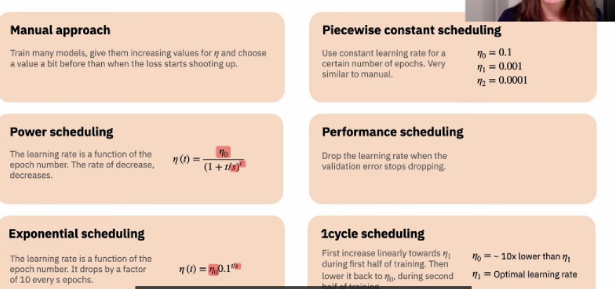

In [22]:
# # Old model #
# def create_model():
#     model = Sequential([
#         Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
#         Activation('relu'),
#         MaxPooling2D(pool_size=(2, 2)),
#         BatchNormalization(),
# #         Dropout(0.5),

#         Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
#         Activation('relu'),
#         MaxPooling2D(pool_size=(2, 2)),
#         BatchNormalization(),
# #         Dropout(0.5),

#         Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
#         Activation('relu'),
#         MaxPooling2D(pool_size=(2, 2)),
#         BatchNormalization(),

#         Flatten(),
        
#         Dense(units=256, activation='relu'),
#         Dropout(0.5),
#         Dense(units=2, activation='softmax')
#     ])
    
#     return model

In [23]:
# cnn_model = create_model()
cnn_model = resnet50()
# print(cnn_model.summary())
# BATCH_SIZE = 1
cnn_model.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 100, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 100, 64) 256         conv2d[0][0]                     
___________________________________________________________________________________________

#### **a. Reduce Learning Rate on Plateau**

Is used to reduce the learning rate when a metric has stopped improving.

In [24]:
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', fiiactor=np.sqrt(0.1), patience=5)
# optimizer = Adam(learning_rate=0.001)
# cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [25]:
# cnn_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


#### **v. Training the Model**

In [26]:
# cnn_model.compile(loss='categorical_crossentropy', 
#                   optimizer=Adam(learning_rate=1e-3), 
#                   metrics=['accuracy'])
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#                     initial_learning_rate=1e-2,
#                     decay_steps=100_000,
#                     decay_rate=0.70)
n_epochs = 50
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=1e-2,
                    decay_steps=100_000,
                    decay_rate=0.7)


cnn_model.compile(loss='categorical_crossentropy', 
                  optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule), 
                  metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = cnn_model.fit(train_generator, 
                        epochs=n_epochs,
                        callbacks = [es],
                        validation_data=validation_generator)

Epoch 1/50
28/28 [==============================] - 14s 250ms/step - loss: 32.3264 - accuracy: 0.5487 - val_loss: 35.2711 - val_accuracy: 0.5217
Epoch 2/50
28/28 [==============================] - 4s 136ms/step - loss: 25.0574 - accuracy: 0.5397 - val_loss: 19.3442 - val_accuracy: 0.5163
Epoch 3/50
28/28 [==============================] - 4s 138ms/step - loss: 22.9209 - accuracy: 0.6227 - val_loss: 24.5212 - val_accuracy: 0.5380
Epoch 4/50
28/28 [==============================] - 4s 137ms/step - loss: 20.7368 - accuracy: 0.6949 - val_loss: 20.6776 - val_accuracy: 0.6141
Epoch 5/50
28/28 [==============================] - 4s 136ms/step - loss: 18.8887 - accuracy: 0.7762 - val_loss: 20.9344 - val_accuracy: 0.6739
Epoch 6/50
28/28 [==============================] - 4s 136ms/step - loss: 18.7314 - accuracy: 0.7978 - val_loss: 21.1743 - val_accuracy: 0.4783
Epoch 7/50
28/28 [==============================] - 4s 136ms/step - loss: 19.4027 - accuracy: 0.7690 - val_loss: 18.5985 - val_accuracy

In [27]:
# history.history

In [28]:
vars(lr_schedule)

{'initial_learning_rate': 0.01,
 'decay_steps': 100000,
 'decay_rate': 0.7,
 'staircase': False,
 'name': None}

In [29]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# learning_rate = history.history['']

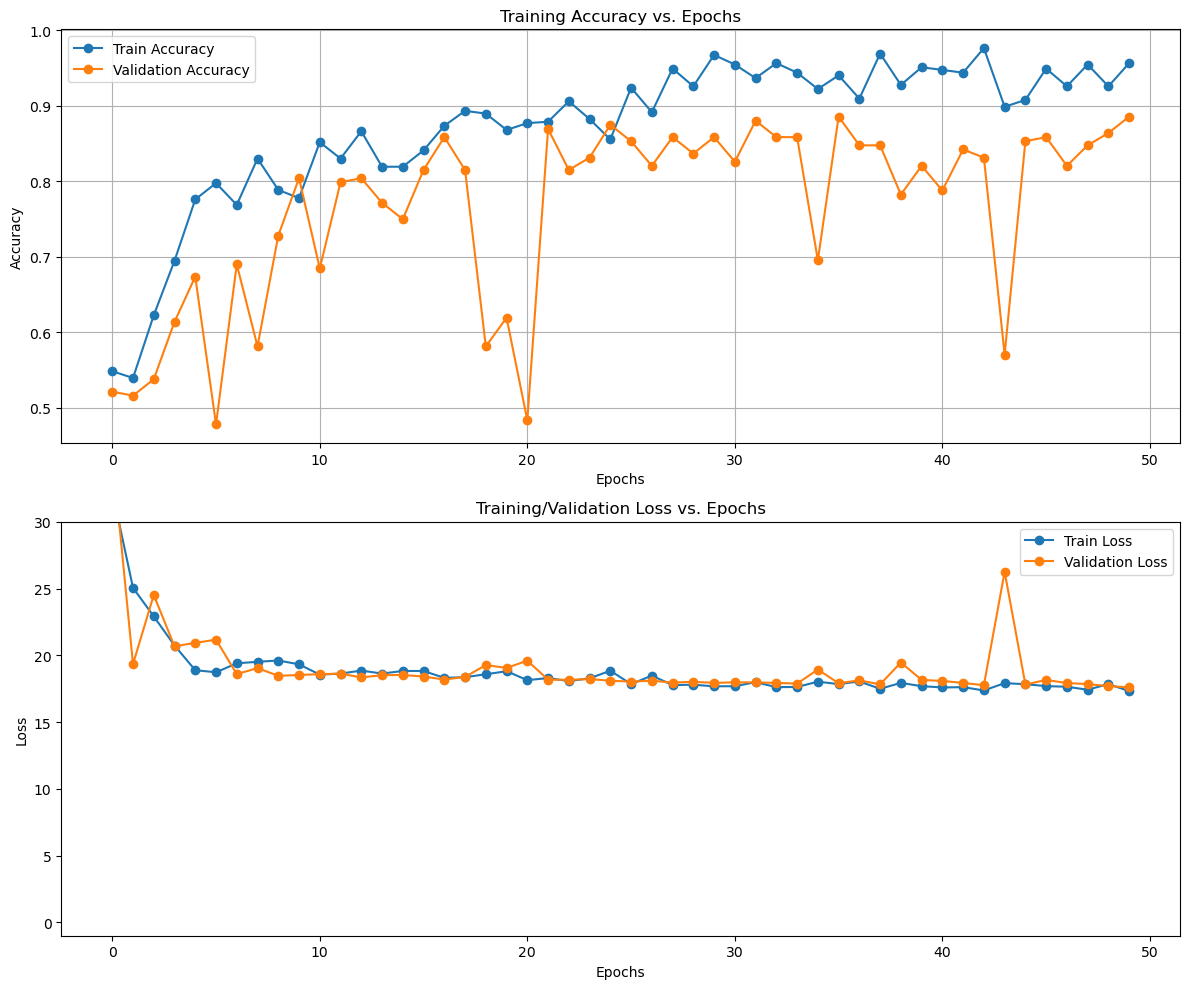

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')
ax[0].grid()

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_ylim([-1, 30])
ax[1].legend(loc='best')

# ax[2].set_title('Learning Rate vs. Epochs')
# ax[2].plot(learning_rate, 'o-', label='Learning Rate')
# ax[2].set_xlabel('Epochs')
# ax[2].set_ylabel('Learning Rate')
# ax[2].legend(loc='best')

# ax[3].set_title('Loss vs learning rate')
# # ax[3].plot(learning_rate, 'o-', label='Learning Rate')
# ax[3].plot(learning_rate, train_loss, 'o-', label='Train Loss')
# ax[3].plot(learning_rate, val_loss, 'o-', label='Validation Loss')
# ax[3].set_ylabel('Loss')
# ax[3].set_xlabel('Learning Rate')
# ax[3].legend(loc='best')

plt.tight_layout()
plt.show()

In [31]:
predictions = cnn_model.predict(test_generator)

In [32]:
# img0 = test_generator[2][0]
# plt.figure()
# plt.imshow(img0)
# plt.show()

In [33]:
# fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
# idx = 0

# for i in range(2):
#     for j in range(5):
#         predicted_label = unique_labels[np.argmax(predictions[idx])]
#         ax[i, j].set_title(f"{predicted_label}", fontsize=10)
#         ax[i, j].imshow(test_generator[idx][0])
        
#         ax[i, j].axis("off")
#         idx += 1

# # plt.tight_layout()
# plt.suptitle("Test Dataset Predictions", fontsize=20)
# plt.show()

In [34]:
test_loss, test_accuracy = cnn_model.evaluate(validation_generator, batch_size=1) # needs to be divisible

10/10 [==============================] - 0s 40ms/step - loss: 17.6055 - accuracy: 0.8859


In [35]:
y_pred = np.argmax(predictions, axis=1)
y_true = testDf['labels']
y_true = y_true.tolist()
# len(y_pred) == len(y_true)
unique_labels = {value: key for key, value in train_generator.class_indices.items()}

# print("Label Mappings for classes present in the training and validation datasets\n")
# for key, value in unique_labels.items():
#     print(f"{key} : {value}")

In [36]:
# function to return key for any value
def get_key(val):
    for key, value in unique_labels.items():
        if val == value:
            return key
 
    return "key doesn't exist"

Y_true = []
# for i in range(len(y_true)): # This was the original way to do it -- be careful, this only solved a mismatch and could be wrong
for i in range(len(y_pred)):
    Y_true.append(get_key(y_true[i]))

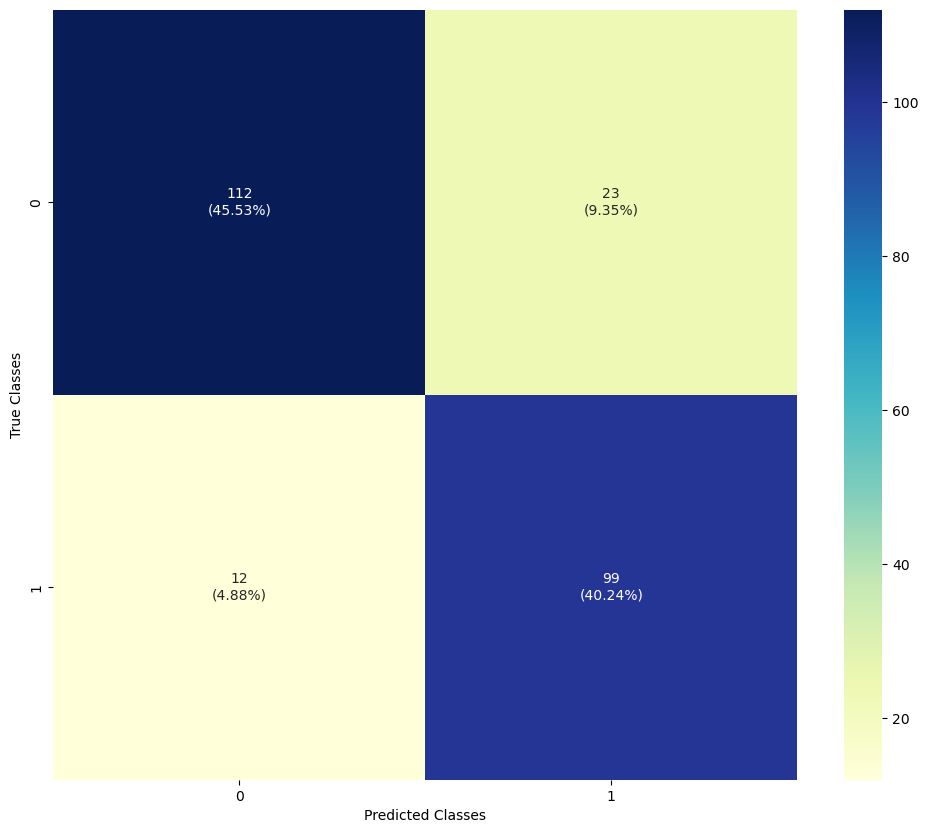

In [37]:
cf_mtx = confusion_matrix(Y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(2, 2)

plt.figure(figsize = (12, 10))
# sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
#            cmap="YlGnBu", fmt="", annot=box_labels)
sns.heatmap(cf_mtx, cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [38]:
# cf_mtx.sum()

In [39]:
y_true = np.array([int(x) for x in y_true]) # cast to np array for type consistency with y_pred
errors = (y_true - y_pred != 0) # everywhere the numbers don't match
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [40]:
test_images = test_generator.filenames
test_img_err = np.asarray(test_images)[errors]

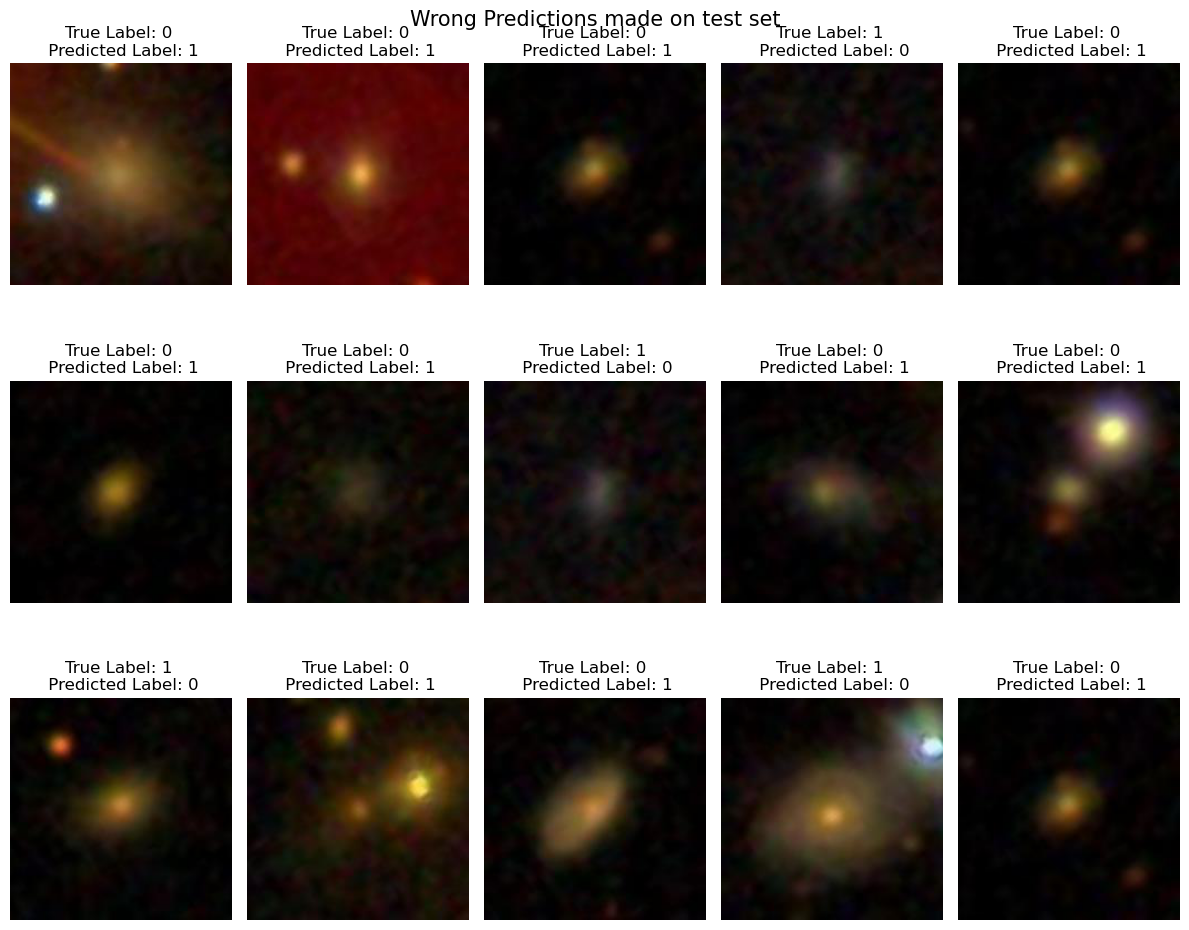

In [41]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(12, 10))
idx = 0

for i in range(3):
    for j in range(5):
        idx = np.random.randint(0, len(test_img_err))
        true_index = y_true_errors[idx]
        true_label = unique_labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = unique_labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        ax[i, j].imshow(test_generator[idx][0])
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=15)
plt.show()

In [42]:
hits = (y_true - y_pred == 0)
y_true_hits = y_true[hits]
y_pred_hits = y_pred[hits]

In [43]:
test_img_hits = np.asarray(test_images)[hits]

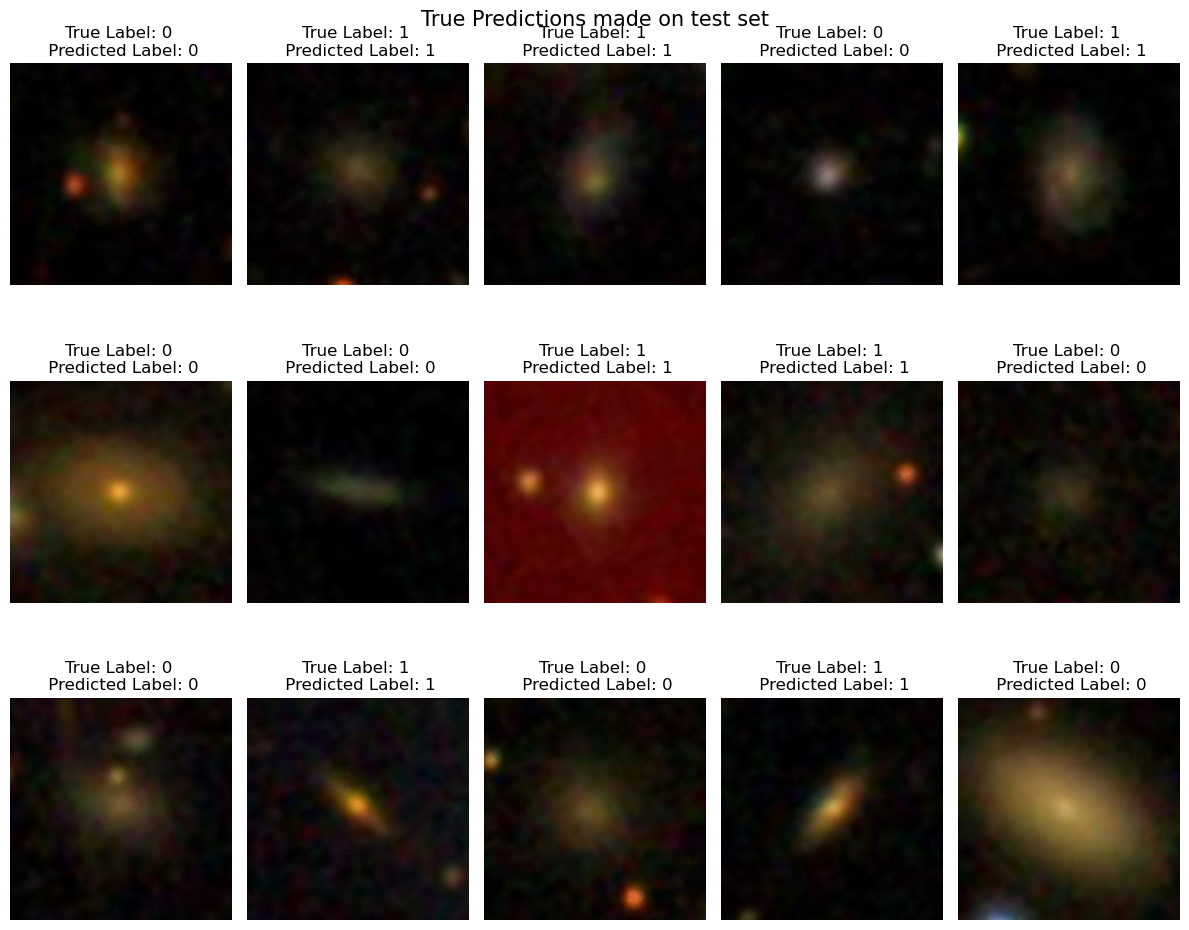

In [44]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(12, 10))
idx = 0

for i in range(3):
    for j in range(5):
        idx = np.random.randint(0, len(test_img_hits))
        true_index = y_true_hits[idx]
        true_label = unique_labels[true_index]
        predicted_index = y_pred_hits[idx]
        predicted_label = unique_labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        ax[i, j].imshow(test_generator[idx][0])
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('True Predictions made on test set', fontsize=15)
plt.show()

# End result:

In [45]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     17.60546112060547
Test Accuracy: 0.885869562625885
